logits = raw model output values


### Dino V1 selbst implementieren

DINO (Self-DIstillation with NO Labels)

DINO uses Vision Transformers (ViTs) and employs self-distillation, where a student model learns by aligning its outputs with a dynamically updated teacher model. This approach leads to the emergence of visual prototypes without the need for labeled data.

#### Knowledge Distillation
Knowledge distillation is a powerful technique aimed at transferring the knowledge from a larger, more complex model (referred to as the "teacher" network) to a smaller, simpler model (known as the "student" network).
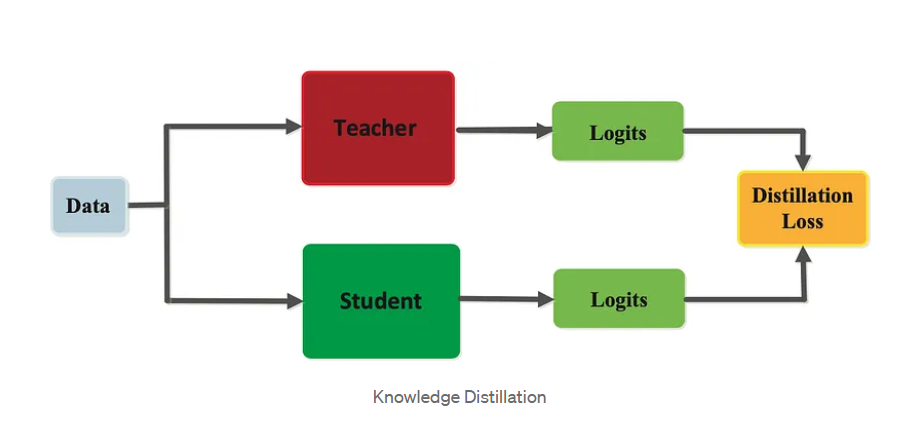

Given an input image x, both networks generate probability distributions over K dimensions, symbolized by Pt​ and Ps​ for the teacher and student networks respectively.

The probability P is calculated by normalizing the output of the network g using the Softmax activation function. Mathematically, the student's output probability Ps​(x) for each class i is computed as:
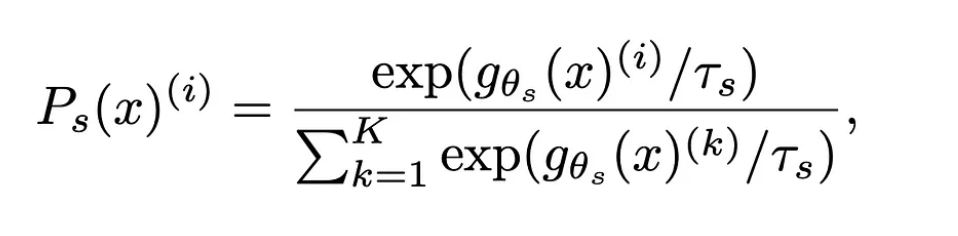
where τs​ is a positive temperature parameter that controls the sharpness of the output distribution. A similar formula is used to calculate Pt​ for the teacher network, with its own temperature parameter τt​.

In simpler terms, knowledge distillation guides the Student to produce outputs similar to that of the Teacher by adjusting its parameters θs​ such that the KL Divergence loss is minimized. This process allows the student network to learn from the rich representations encoded by the teacher, thereby improving its own performance even when trained on a smaller dataset or having a simpler architecture.



#### The Essence of Self-Supervision and Contrastive Learning
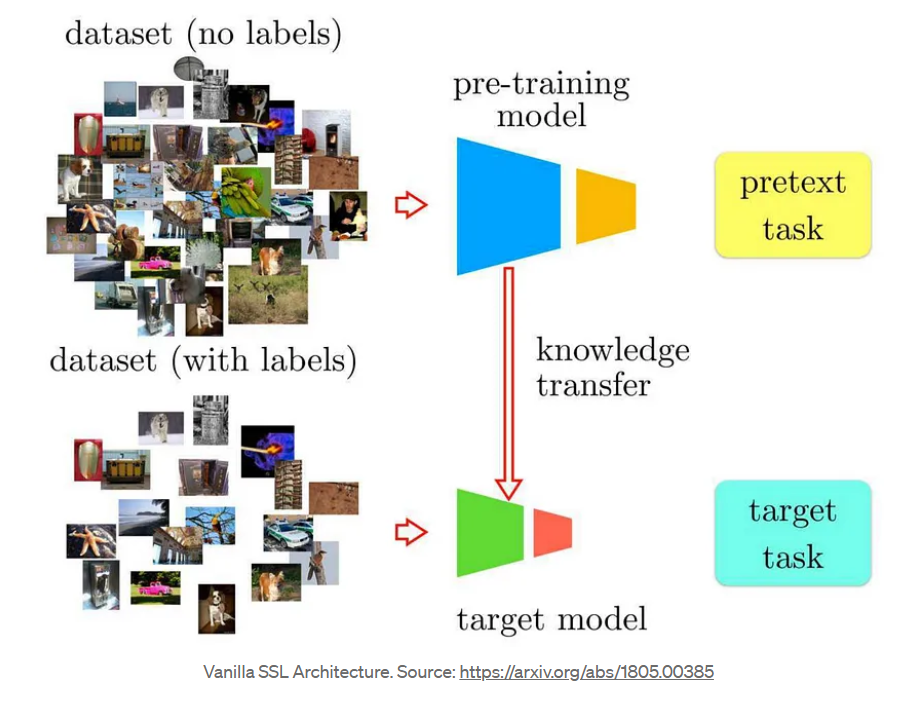
Among the various techniques in self-supervised learning, contrastive learning is notable. It focuses on teaching the model to differentiate between similar (positive) and dissimilar (negative) pairs of data.

#### Self-Supervised Learning (SSL) with Knowledge Distillation: A Comparison

As we saw above, traditional knowledge distillation involves training a smaller student model to imitate the predictions of a larger pre-trained teacher model. However, DINO takes a distinctive twist on this concept.

#### Traditional Knowledge Distillation
Teacher Model: A pre-trained, larger model, usually frozen during training.

Student Model: A smaller model, trained via back-propagation to mimic the teacher’s predictions.

Objective: Transfer knowledge from the teacher’s weight distribution to the student.

Model Diversity: Teacher and student can be different models, e.g., ResNet50 (Teacher) and SqueezeNet (Student).

Loss Function: Typically uses KL Divergence loss on the output logits of both models.

#### SSL with DINO (DIstillation of NOisy labels)
DINO introduces a unique approach to knowledge distillation.

1. Multi-crop Strategy: DINO generates various distorted views (crops) from an image, including two global views and several lower-resolution local views, using different augmentations.
2. Local-to-Global Learning: All crops are passed through the student model, but only global views are processed by the teacher model. This teaches the student to relate local image patches with the global context from the teacher.
3. Loss Minimization: The goal is to minimize a loss function measuring the similarity of representations from the student and teacher for different views of the same image, without using labeled data

#### Model Architecture
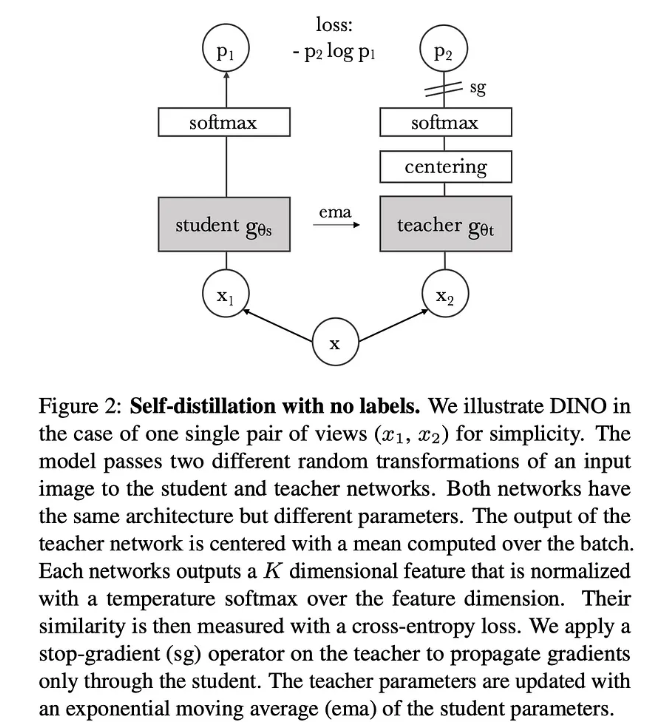

1. Weight Updates: The Student model is trained using back-propagation, and its weights are used to update the Teacher model using Exponential Moving Average (EMA).
2. Dynamic Teacher: The teacher model is updated dynamically, preventing the student from overfitting to static representations. If the Teacher model weights were static (i.e., not updated), the Student might quickly overfit to the specific representations provided by that static Teacher. By having a dynamically updated teacher, the Student constantly adapts to slightly changing targets, promoting better generalization.
3. Loss Calculation: The cross-entropy loss is computed based on the probability distribution obtained from applying softmax to the logits from both models.


#### Comparative Analysis
So, what distinguishes Knowledge Distillation from SSL with DINO?
1. Model Dynamics: In traditional distillation, only the student model is trained, while in DINO, both models are updated.
2. Architectural Flexibility: Knowledge Distillation allows for different model architectures, whereas DINO requires identical architectures to ensure effective weight updates.
3. Loss Function: DINO focuses on contrastive learning, emphasizing representations similarity, while traditional distillation uses KL Divergence loss. For DINO, the positive pair (the representation from the Teacher corresponding to the same image as the Student) is treated as the “true class”, and the cross-entropy loss is computed based on this distribution.

#### Defining Positive/Negative Pairs and Similarity Computation
In DINO, positive pairs are defined as differently augmented views of the same image, while negative pairs stem from augmentations of other images. The cosine similarity metric is employed for computing similarities between these pairs.


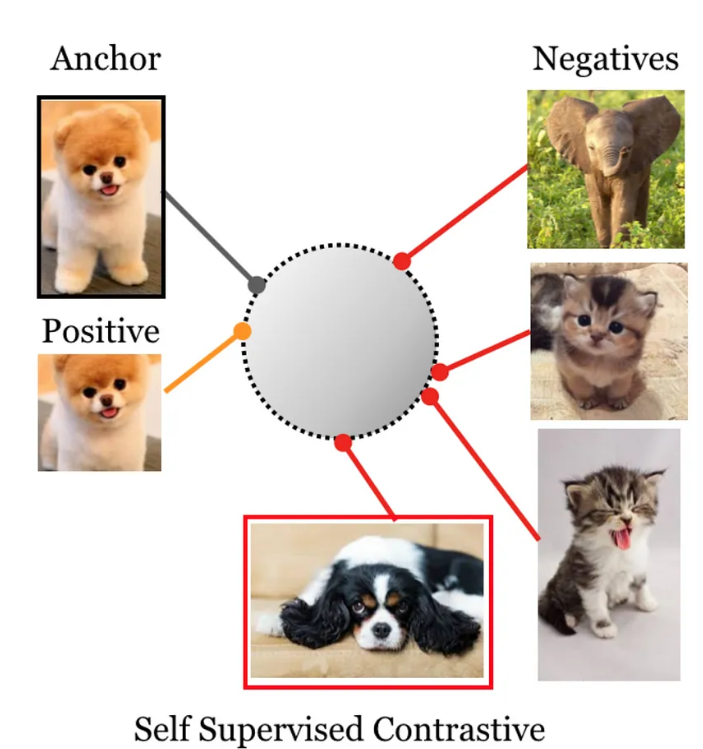


#### Loss Function
-> Cross-Entropy Loss: The cross-entropy loss is calculated based on the probability distributions obtained from the softmax function applied to the logits of both the student and teacher models. The loss is minimized to ensure that the student model's outputs align with those of the teacher model.
E.g. batch of 3 images -> student representation s
- teacher outputs [t1, t2, t3]
- similarities (logites) between s and teacher output are [0.9, 0.8, 0.7]
- cross-entropy loss is calculated for each image -> t1 is the true clas

- for each representation from the student (s) a similarity score (e..g dot product) is calculated with all teacher outputs
- the similarity score is used to calculate the cross-entropy loss
- position corresponding to the teacher's representation of the same image (positive pair) is treated as the true class and the cross entropy loss is calculated

In essence, DINO's cross-entropy loss contrasts the student's representation against a dynamic vocabulary of prototypes from the teacher's output. This setup allows the model to learn meaningful representations in a self-supervised manner without the need for a final classification layer or explicit labels.

DINO adapts the traditional cross-entropy loss to operate directly on the output embeddings. This adaptation ensures that the loss can be computed without the need for a linear classification layer at the output.

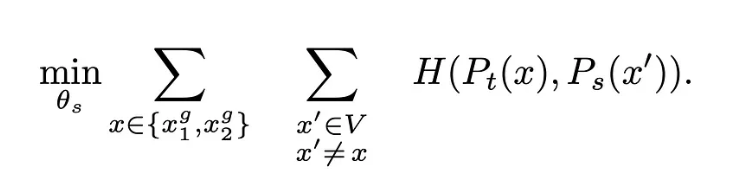


#### Exponential Moving Averages (EMA)
- stabaliszes the training process by mitigating abrupt fluctuations in the model weights
- teachers parameters undergo continual update as follows:
- θt​ = α * θt​ + (1 - α) * θs​
--> where α is a momentum term that balances the contribution of the current and previous weights.

#### Avoiding Model Collapse
Centering, Sharpening, and Vocabulary of Prototypes
- Centering ensures zero-centered features
- sharpening accentuates the differences between positive and negative pairs.
- Additionally, DINO learns a dynamic vocabulary of visual prototypes, which are activation patterns representing diverse visual concepts.

#### TLDR
1. Init: Initialize the student and teacher models with identical architectures. Params are randomly initialized.
2. Multi-Crop Augmentation: Load batch of images. For each image, generate multiple views (crops) using different augmentations.
3. Forward pass: Pass augmented images through the student and teacher models. Compute the logits for each view.
4. Contrastive Loss Calc: Calc constrastive loss using output logits from both models. This is done by identifying positive (similar) and negative (dissimilar) pairs and computing the cross-entropy loss.
5. Backpropagation and Weight Update: Back-propagate through Student model to update its weights. Update teacher weights by taling Exponential Moving Average (EMA) of the students updated weights. Apply centering and sharpness adjustments this EMA update.

DINO Aufbau:
Student-Teacher-Training


Plan: 
1. DinoV1 implementieren und mit bekanntem Datensatz testen
2. DinoV1 mit eigenen Daten testen
3. DinoV2 implementieren und mit bekanntem Datensatz testen
4. DinoV2 mit eigenen Daten testen


In [52]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.transforms.functional as F

from PIL import Image

import os
import pathlib
from torch.utils.tensorboard import SummaryWriter
import timm
import tqdm
from torch.utils.data import SubsetRandomSampler
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.utils.data import DataLoader, DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from  torch.nn.parallel import DataParallel as DP
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
class Organoid(Dataset):
    def __init__(
        self,
        root,
        n_local_crops=8,
        apply_transforms=True,
        augmentations=None,
        size=224
    ):
        """
        Args:
            root (str): Pfad zum Ordner, der die Organoid-Bilder enthält.
            n_local_crops (int): Anzahl an 'lokalen' Crops, die erstellt werden sollen.
            apply_transforms (bool): Flag, ob überhaupt Augmentations angewendet werden sollen.
            augmentations (dict or None): Falls ein dict übergeben wird, kann es eigene
                                          Transformation-Pipelines für 'global_1', 'global_2' 
                                          und 'local' enthalten. Ansonsten werden Defaults verwendet.
            size (int): Ziel-Auflösung für das Transform-Resize.
        """
        self.root = root
        self.imgs = sorted([img for img in os.listdir(root) if "mask" not in img])
        self.apply_transforms = apply_transforms
        self.size = size
        self.n_local_crops = n_local_crops

        # Standard-Skalierungsfaktoren gemäß BYOL-/DINO-Ähnlichen Setups
        global_crops_scale = (0.5, 0.9)
        local_crops_scale = (0.05, 0.4)

        # Gemeinsamer Normalisierungs-Transform
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((size, size)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        # Beispiel für leichte Augmentation: horizontales Flip & Gaussian Blur
        flip_and_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            # Keine Farb- oder Grayscale-Änderungen,
            # da Farben vom Modell gelernt werden sollen
        ])

        # Häufig in DINO verwendete Operation: selektives Anwenden von GaussianBlur
        RandomGaussianBlur = lambda p: transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2))], p=p
        )

        # -- Default-Augmentationen --
        # "Global View" 1
        default_global_1 = transforms.Compose([
            transforms.RandomResizedCrop(
                size, scale=global_crops_scale, interpolation=Image.BICUBIC
            ),
            flip_and_jitter,
            normalize
        ])

        # "Global View" 2 (mit leicht unterschiedlicher Wahrscheinlichkeit für Blur)
        default_global_2 = transforms.Compose([
            transforms.RandomResizedCrop(
                size, scale=global_crops_scale, interpolation=Image.BICUBIC
            ),
            RandomGaussianBlur(0.1),
            normalize
        ])

        # "Local View" (kleinere Crops, häufiger Blur)
        default_local = transforms.Compose([
            transforms.RandomResizedCrop(
                size, scale=local_crops_scale, interpolation=Image.BICUBIC
            ),
            flip_and_jitter,
            RandomGaussianBlur(0.5),
            normalize
        ])

        # Wenn von außen kein eigenes Augmentations-Dict übergeben wird,
        # verwende die Default-Augmentations
        self.augmentations = augmentations or {
            "global_1": default_global_1,
            "global_2": default_global_2,
            "local": default_local,
            "n_local_crops": self.n_local_crops,
        }

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Bild öffnen
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        # Label extrahieren (z. B. aus Dateinamen '_XYZ.jpg' => XYZ-100 => Label)
        img_name = os.path.basename(img_path)
        num_part = int(img_name.split('_')[-1].split('.')[0])
        label = (num_part // 100) - 1

        if self.apply_transforms:
            # Wende definierte Augmentations an (entweder Default oder von außen übergeben)
            all_crops = [
                self.augmentations["global_1"](img),
                self.augmentations["global_2"](img),
            ]
            all_crops.extend([
                self.augmentations["local"](img)
                for _ in range(self.augmentations["n_local_crops"])
            ])

            # Originalbild als Referenz (ohne Augmentation, nur Resize + ToTensor)
            orig_img_tensor = transforms.ToTensor()(img)
            orig_img_tensor = transforms.Resize((self.size, self.size))(orig_img_tensor)

            return all_crops, orig_img_tensor, label

        else:
            # Falls man keine Transforms anwenden will (reines Laden + Normalisieren/Resize)
            orig_img_tensor = transforms.ToTensor()(img)
            orig_img_tensor = transforms.Resize((self.size, self.size))(orig_img_tensor)
            return orig_img_tensor, label

In [54]:
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch

In [55]:
imgs_path = "./ds/organoid/train-100"

dataset_train_aug = Organoid(
    imgs_path, apply_transforms=True
)


In [56]:
# De-normalisierungsfunktion
def denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    img_tensor = torch.tensor(img_tensor)  # Ensure input is a tensor
    img_tensor = img_tensor * std + mean
    return img_tensor.numpy()

In [57]:
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

@widgets.interact
def visualize_dataset(
    i=widgets.IntSlider(min=0, max=9, continuous_update=False),
    seed=widgets.IntSlider(min=0, max=50, continuous_update=False),
):
    # Setze den Seed für Reproduzierbarkeit
    torch.manual_seed(seed)

    # Hole das Bild und die Crops aus dem Dataset
    result = dataset_train_aug[i]
    all_crops, original_img, label = result

    # Global Crops de-normalisieren
    global_1 = denormalize(all_crops[0].permute(1, 2, 0).numpy())
    global_2 = denormalize(all_crops[1].permute(1, 2, 0).numpy())

    # Lokale Crops de-normalisieren
    local_crops = [denormalize(crop.permute(1, 2, 0).numpy()) for crop in all_crops[2:]]

    # Anzahl der Subplots berechnen
    total_crops = 2 + len(local_crops)  # 2 globale Crops + lokale Crops
    rows = (total_crops + 2) // 3  # Drei Bilder pro Zeile

    # Eine zentrale Figur erstellen
    fig, axs = plt.subplots(rows, 3, figsize=(12, 4 * rows))
    axs = axs.flatten()  # Flache Liste für einfachen Zugriff

    # Originalbild de-normalisieren und anzeigen
    original_img = original_img.permute(1, 2, 0).numpy()
    axs[0].imshow(original_img)
    axs[0].set_title(f"Original (Label: {label})")
    axs[0].axis("off")

    # Globale Crops anzeigen
    axs[1].imshow(global_1)
    axs[1].set_title("Global Crop 1")
    axs[1].axis("off")

    axs[2].imshow(global_2)
    axs[2].set_title("Global Crop 2")
    axs[2].axis("off")

    # Lokale Crops anzeigen
    for j, local_crop in enumerate(local_crops):
        axs[3 + j].imshow(local_crop)
        axs[3 + j].set_title(f"Local Crop {j + 1}")
        axs[3 + j].axis("off")

    # Restliche Achsen ausblenden, falls weniger Crops als Subplots
    for ax in axs[3 + len(local_crops):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Explizites Schließen der Figur
    plt.close(fig)


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=9), IntSlider(value=0, …

In [58]:
class Head(nn.Module):
    """Network hooked up to the CLS token embedding.

    Just a MLP with the last layer being normalized in a particular way.

    Parameters
    ----------
    in_dim : int
        The dimensionality of the token embedding.

    out_dim : int
        The dimensionality of the final layer (we compute the softmax over).
        im paper: 65k

    hidden_dim : int
        Dimensionality of the hidden layers.

    bottleneck_dim : int
        Dimensionality of the second last layer.

    n_layers : int
        The number of layers.

    norm_last_layer : bool
        If True, then we freeze the norm of the weight of the last linear layer
        to 1.

    Attributes
    ----------
    mlp : nn.Sequential
        Vanilla multi-layer perceptron.

    last_layer : nn.Linear
        Reparametrized linear layer with weight normalization. That means
        that that it will have `weight_g` and `weight_v` as learnable
        parameters instead of a single `weight`.
    """

    def __init__(
        self,
        in_dim,
        out_dim,
        hidden_dim=512,
        bottleneck_dim=256,
        n_layers=3,
        norm_last_layer=False,
    ):
        super().__init__()
        if n_layers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            layers.append(nn.GELU())
            for _ in range(n_layers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)

        self.apply(self._init_weights)

        self.last_layer = nn.utils.weight_norm(
            nn.Linear(bottleneck_dim, out_dim, bias=False)
        )
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        """Initialize learnable parameters."""
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Of shape `(n_samples, in_dim)`.

        Returns
        -------
        torch.Tensor
            Of shape `(n_samples, out_dim)`.
        """
        x = self.mlp(x)  # (n_samples, bottleneck_dim)
        x = nn.functional.normalize(x, dim=-1, p=2)  # (n_samples, bottleneck_dim)
        x = self.last_layer(x)  # (n_samples, out_dim)

        return x

In [59]:
class MultiCropWrapper(nn.Module):
    """Convenience class for forward pass of multiple crops.

    Parameters
    ----------
    backbone : timm.models.vision_transformer.VisionTransformer
        Instantiated Vision Transformer. Note that we will take the `head`
        attribute and replace it with `nn.Identity`.

    new_head : Head
        New head that is going to be put on top of the `backbone`.
    """
    def __init__(self, backbone, new_head):
        super().__init__()
        backbone.head = nn.Identity()  # deactivate original head
        self.backbone = backbone
        self.new_head = new_head

    def forward(self, x):
        """Run the forward pass.

        The different crops are concatenated along the batch dimension
        and then a single forward pass is fun. The resulting tensor
        is then chunked back to per crop tensors.

        Parameters
        ----------
        x : list
            List of `torch.Tensor` each of shape `(n_samples, 3, size, size)`.

        Returns
        -------
        tuple
            Tuple of `torch.Tensor` each of shape `(n_samples, out_dim)` where
            `output_dim` is determined by `Head`.
        """
        n_crops = len(x)
        concatenated = torch.cat(x, dim=0)  # (n_samples * n_crops, 3, size, size)
        cls_embedding = self.backbone(concatenated)  # (n_samples * n_crops, in_dim)
        logits = self.new_head(cls_embedding)  # (n_samples * n_crops, out_dim)
        chunks = logits.chunk(n_crops)  # n_crops * (n_samples, out_dim)

        return chunks

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [61]:

class Loss(nn.Module):
    """The loss function.

    We subclass the `nn.Module` becuase we want to create a buffer for the
    logits center of the teacher.

    Parameters
    ----------
    out_dim : int
        The dimensionality of the final layer (we computed the softmax over).

    teacher_temp, student_temp : float
        Softmax temperature of the teacher resp. student.

    center_momentum : float
        Hyperparameter for the exponential moving average that determines
        the center logits. The higher the more the running average matters.
    """
    def __init__(
        self, out_dim, teacher_temp=0.04, student_temp=0.1, center_momentum=0.9
    ):
        super().__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim))

    def forward(self, student_output, teacher_output):
        """Evaluate loss.

        Parameters
        ----------
        student_output, teacher_output : tuple
            Tuple of tensors of shape `(n_samples, out_dim)` representing
            logits. The length is equal to number of crops.
            Note that student processed all crops and that the two initial crops
            are the global ones.

        Returns
        -------
        loss : torch.Tensor
            Scalar representing the average loss.
        """
        student_temp = [s / self.student_temp for s in student_output]
        teacher_temp = [(t - self.center) / self.teacher_temp for t in teacher_output]

        student_sm = [F.log_softmax(s, dim=-1) for s in student_temp]
        teacher_sm = [F.softmax(t, dim=-1).detach() for t in teacher_temp]

        total_loss = 0
        n_loss_terms = 0

        for t_ix, t in enumerate(teacher_sm):
            for s_ix, s in enumerate(student_sm):
                if t_ix == s_ix:
                    continue

                loss = torch.sum(-t * s, dim=-1)  # (n_samples,)
                total_loss += loss.mean()  # scalar
                n_loss_terms += 1

        total_loss /= n_loss_terms
        self.update_center(teacher_output)

        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """Update center used for teacher output.

        Compute the exponential moving average.

        Parameters
        ----------
        teacher_output : tuple
            Tuple of tensors of shape `(n_samples, out_dim)` where each
            tensor represents a different crop.
        """
        batch_center = torch.cat(teacher_output).mean(
            dim=0, keepdim=True
        )  # (1, out_dim)
        self.center = self.center * self.center_momentum + batch_center * (
            1 - self.center_momentum
        )

    @torch.no_grad()
    def update_center(self, teacher_output):
        """Update center used for teacher output.

        Compute the exponential moving average.

        Parameters
        ----------
        teacher_output : tuple
            Tuple of tensors of shape `(n_samples, out_dim)` where each
            tensor represents a different crop.
        """
        batch_center = torch.cat(teacher_output).mean(
            dim=0, keepdim=True
        )  # (1, out_dim)
        self.center = self.center * self.center_momentum + batch_center * (
            1 - self.center_momentum
        )


def clip_gradients(model, clip=2.0):
    """Rescale norm of computed gradients.

    Parameters
    ----------
    model : nn.Module
        Module.

    clip : float
        Maximum norm.
    """
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            clip_coef = clip / (param_norm + 1e-6)
            if clip_coef < 1:
                p.grad.data.mul_(clip_coef)

In [62]:
import pathlib
from torch.utils.tensorboard import SummaryWriter
import timm
import tqdm
from torch.utils.data import SubsetRandomSampler

In [63]:
# free cuda memory
torch.cuda.empty_cache()

In [64]:
# EVAL

import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


def compute_knn(backbone, data_loader_train, data_loader_val):
    """Get CLS embeddings and use KNN classifier on them.

    We load all embeddings in memory and use sklearn. Should
    be doable.

    Parameters
    ----------
    backbone : timm.models.vision_transformer.VisionTransformer
        Vision transformer whose head is just an identity
        mapping.

    data_loader_train, data_loader_val : torch.utils.data.DataLoader
        Training and validation dataloader that does not apply any
        augmentations. Just casting to tensor and then normalizing.

    Returns
    -------
    val_accuracy : float
        Validation accuracy.
    """
    device = next(backbone.parameters()).device

    data_loaders = {
        "train": data_loader_train,
        "val": data_loader_val,
    }
    lists = {
        "X_train": [],
        "y_train": [],
        "X_val": [],
        "y_val": [],
    }

    for name, data_loader in data_loaders.items():
        for imgs, y in data_loader:
            imgs = imgs.to(device)
            lists[f"X_{name}"].append(backbone(imgs).detach().cpu().numpy())
            lists[f"y_{name}"].append(y.detach().cpu().numpy())

    arrays = {k: np.concatenate(l) for k, l in lists.items()}

    estimator = KNeighborsClassifier()
    estimator.fit(arrays["X_train"], arrays["y_train"])
    y_val_pred = estimator.predict(arrays["X_val"])

    acc = accuracy_score(arrays["y_val"], y_val_pred)

    return acc

def compute_embedding(backbone, data_loader):
    """Compute CLS embedding and prepare for TensorBoard.

    Parameters
    ----------
    backbone : timm.models.vision_transformer.VisionTransformer
        Vision transformer. The head should be an identity mapping.

    data_loader : torch.utils.data.DataLoader
        Validation dataloader that does not apply any augmentations. Just
        casting to tensor and then normalizing.

    Returns
    -------
    embs : torch.Tensor
        Embeddings of shape `(n_samples, out_dim)`.

    imgs : torch.Tensor
        Images of shape `(n_samples, 3, height, width)`.

    labels : list
        List of strings representing the classes.
    """
    device = next(backbone.parameters()).device

    # print dataloader length
    # print(len(data_loader))

    embs_l = []
    imgs_l = []
    labels = []

    for img, label in data_loader:
        img = img.to(device)
        embs_l.append(backbone(img).detach().cpu())
        # undo normalization (norm was 0.5 on all channels)
        # img = denormalize(img)
        imgs_l.append(img.cpu())
        labels.extend(label)

    embs = torch.cat(embs_l, dim=0)
    imgs = torch.cat(imgs_l, dim=0)

    return embs, imgs, labels

In [70]:
student, data_loader_val_plain_subset, val_path = None, None, None

In [71]:
def evaluate_cosine_similarity(embeddings, pos_pairs, neg_pairs):
    pos_sim = [F.cosine_similarity(embeddings[i], embeddings[j], dim=0).item() for i, j in pos_pairs]
    neg_sim = [F.cosine_similarity(embeddings[i], embeddings[j], dim=0).item() for i, j in neg_pairs]
    avg_pos_sim = np.mean(pos_sim)
    avg_neg_sim = np.mean(neg_sim)
    return avg_pos_sim, avg_neg_sim

In [75]:
val_path =  "./ds/organoid/test-100"
dataset_val_plain = Organoid(val_path, apply_transforms=False)


data_loader_val_plain = DataLoader(
    dataset_val_plain,
    batch_size=1,
    drop_last=False,
    num_workers=0,
)
data_loader_val_plain_subset = DataLoader(
    dataset_val_plain,
    batch_size=1,
    drop_last=False,
    # sampler=SubsetRandomSampler(list(range(0, len(dataset_val_plain), 50))),
    sampler=SubsetRandomSampler(list(range(0, len(dataset_val_plain)))),
    num_workers=0,
)

In [ ]:
embs, imgs, labels = None, None, None

def train(args):
    global embs, imgs, labels 

    vit_name, dim = "vit_base_patch16_224", 768

    # Dataset paths
    # imgs_path = "./ds/organoid/train-100"
    imgs_path = "./ds/organoid/train-100"

    dataset_train_aug = Organoid(
        imgs_path, apply_transforms=True
    )

    dataset_train_plain = Organoid(val_path, apply_transforms=False)

    data_loader_train_aug = DataLoader(
        dataset_train_aug,
        batch_size=args["batch_size"],
        shuffle=True,
        drop_last=True,
        num_workers=args["n_workers"],
        pin_memory=True,
    )

    data_loader_train_plain = DataLoader(
        dataset_train_plain,
        batch_size=args["batch_size_eval"],
        drop_last=False,
        num_workers=args["n_workers"],
    )

    logging_path = pathlib.Path("logs")

    # run name
    # params to array 
    run_name = "_".join([f"{k}={v}" for k, v in args.items()])
    import datetime
    current_data_time = datetime.datetime.now().strftime("%d%m_%H_%M%S")
    run_name = f"{current_data_time}"

    print(f"Run name: {run_name}")
    print(f"hparams: {args}")


    writer = SummaryWriter(log_dir=logging_path  / run_name)

    # Neural network related
    student_vit = timm.create_model(vit_name, pretrained=args["pretrained"])
    teacher_vit = timm.create_model(vit_name, pretrained=args["pretrained"])

    student = MultiCropWrapper(
      student_vit,
      Head(
          dim,
          args["out_dim"],
          norm_last_layer=args["norm_last_layer"],
      ),
    )
    teacher = MultiCropWrapper(teacher_vit, Head(dim, args["out_dim"]))

    for p in teacher.parameters():
        p.requires_grad = False

    # Loss related
    loss_inst = Loss(
        args["out_dim"],
        teacher_temp=args["teacher_temp"],
        student_temp=args["student_temp"],
    )

    lr = args["start_lr"] * args["batch_size"] / 256

    optimizer = torch.optim.AdamW(
        student.parameters(),
        lr=lr,
        weight_decay=args["weight_decay"],
    )
    n_batches = len(data_loader_train_aug)


    # Device & DataParallel Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()
    print(f"Anzahl verfügbarer GPUs: {num_gpus}")

    # Erst Modelle auf GPU verschieben
    student = student.to(device)
    teacher = teacher.to(device)

    # Falls mehrere GPUs vorhanden, DataParallel nutzen
    if num_gpus > 1:
        student = nn.DataParallel(student)
        teacher = nn.DataParallel(teacher)
    

    best_acc, loss, current_acc = 0, None, 0
    for e in range(args["n_epochs"]):
        print(f"Epoch {e}")
        for i, (all_crops, original_img, label) in tqdm.tqdm(enumerate(data_loader_train_aug), total=n_batches):
            images = all_crops
            global_step = global_step = e * n_batches + i
            if i % 50 == 0:

                student_for_eval = student.module if isinstance(student, nn.DataParallel) else student
                embs, imgs, labels = compute_embedding(student_for_eval.backbone, data_loader_val_plain_subset)

                kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
                clusters = kmeans.fit_predict(embs)

                nmi  = normalized_mutual_info_score(labels, clusters)
                ars = adjusted_rand_score(labels, clusters)


                current_acc = compute_knn(
                    student_for_eval.backbone,
                    data_loader_train_plain,
                    data_loader_val_plain,
                )

                # kmeans pairwise accuracy
                print(f"ARI: {ars}")
                print(f"NMI: {nmi}")
                print(f"Accuracy: {current_acc}")
                print(f"Best Accuracy: {best_acc}")
                print(f"Global Step: {global_step}")
                if(loss):
                    print(f"loss: {loss.item()}")

                writer.add_embedding(
                    embs,
                    metadata=labels,
                    label_img=imgs,
                    global_step=global_step,
                    tag=f"val_embedding_{current_data_time}",
                )


                writer.add_scalar("accuracy", current_acc, global_step)
                writer.add_scalar("ARI", adjusted_rand_score(labels, clusters), global_step)
                writer.add_scalar("NMI", normalized_mutual_info_score(labels, clusters), global_step)

                # save model
                if nmi > best_acc:
                    torch.save(student, logging_path / f"model_nmi_${best_acc}_run.pth")
                    print(f"Model saved with NMI: {nmi}")
                    best_acc = nmi

                student.train()

            # Training
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            images = [img.to(device) for img in images]
            student, teacher = student.to(device), teacher.to(device)

            teacher_output = teacher(images[:2])  # Global Crops an den Lehrer
            student_output = student(images) # Alle Crops an den Student

            # move losss to device
            loss = loss_inst.to(device)
            loss = loss_inst(student_output, teacher_output).to(device)

            optimizer.zero_grad()
            loss.backward()
            clip_gradients(student, args["clip_grads"])
            optimizer.step()

            # EMA-update des Lehrers
            with torch.no_grad():
                # Wenn DataParallel aktiv ist, sind die Parameter unter .module erreichbar
                s_params = student.module.parameters() if num_gpus>1 else student.parameters()
                t_params = teacher.module.parameters() if num_gpus>1 else teacher.parameters()
                for student_ps, teacher_ps in zip(s_params, t_params):
                    teacher_ps.data.mul_(args["momentum_teacher"])
                    teacher_ps.data.add_(
                        (1 - args["momentum_teacher"]) * student_ps.detach().data
                    )

            writer.add_scalar("train_loss", loss.item(), global_step)

    # add metrics and hparams to tensorboard after training
    hparams = {k: (bool(v) if isinstance(v, np.bool_) 
                    else float(v) if isinstance(v, np.float_) 
                    else v) 
            for k,v in args.items()}
    
    metrics = {"hp/accuracy": current_acc, "hp/ARI": adjusted_rand_score(labels, clusters), "hp/NMI": normalized_mutual_info_score(labels, clusters)}
    print('hparams:', hparams)
    print('metrics:', metrics)
    writer.add_hparams(hparams, metrics)
    writer.close()

In [ ]:
print("start")
# FREE mem of all cudas
torch.cuda.empty_cache()

# randomize args by using random search 
# random search
for i in range(1):
    torch.cuda.empty_cache()
    args = {
        "batch_size": 8,
        "batch_size_eval": 4,
        "n_workers": 0,
        "out_dim": 65536,
        "start_lr": 1e-7, #zw 0.00001 und 0.01
        "n_epochs": 10,
        "clip_grads": np.random.choice([0.1,0.5,1.0, 2.0, 3.0, 4.0]),
        "momentum_teacher": 0.999,
        "norm_last_layer": np.random.choice([True, False]),
        "teacher_temp": np.random.choice([0.1, 0.2,0.5]),
        "student_temp": np.random.choice([0.04, 0.08,0.02]),
        "weight_decay": np.random.choice([0.05, 0.08,0.02]),
        "pretrained": np.random.choice([True, False]),
    }
    train(args)

start
Run name: 1601_00_2728
hparams: {'batch_size': 8, 'batch_size_eval': 4, 'n_workers': 0, 'out_dim': 65536, 'start_lr': 1e-07, 'n_epochs': 10, 'clip_grads': 3.0, 'momentum_teacher': 0.999, 'norm_last_layer': True, 'teacher_temp': 0.5, 'student_temp': 0.04, 'weight_decay': 0.05, 'pretrained': False}


/home/h0/s7903435/.venv/lib64/python3.8/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Anzahl verfügbarer GPUs: 8
Epoch 0


  0%|          | 0/12 [00:00<?, ?it/s]

ARI: 0.47872554950594876
NMI: 0.70111084195933
Accuracy: 0.88
Best Accuracy: 0
Global Step: 0
Model saved with NMI: 0.70111084195933


  0%|          | 0/12 [00:52<?, ?it/s]


KeyboardInterrupt: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [77]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
student = torch.load('./logs/model_$1703_14_1011.pth', weights_only=False)


In [79]:
len(data_loader_val_plain_subset)

100

/home/h0/s7903435/.venv/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI: 0.6414814814814814
NMI: 0.8014686733504528


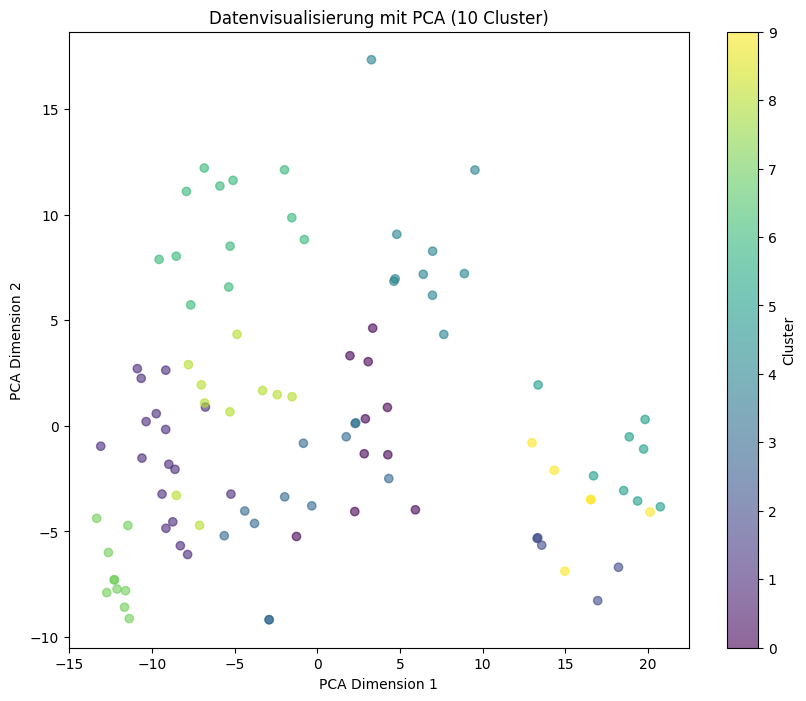

In [ ]:
# get embeddings from model and do knn on them
student_for_eval = student.module if isinstance(student, nn.DataParallel) else student
embs, imgs, labels = compute_embedding(student_for_eval.backbone, data_loader_val_plain_subset)

# do knn
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(embs)

# kmeans pairwise accuracy
adjusted_rand_score(labels, clusters), normalized_mutual_info_score(labels, clusters)
print(f"ARI: {adjusted_rand_score(labels, clusters)}")
print(f"NMI: {normalized_mutual_info_score(labels, clusters)}")


# PCA geht nicht gut! Nicht-Lineare Datenzusammenänge
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(embs)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Datenvisualisierung mit PCA (10 Cluster)')
plt.show()



/home/h0/s7903435/.venv/lib64/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


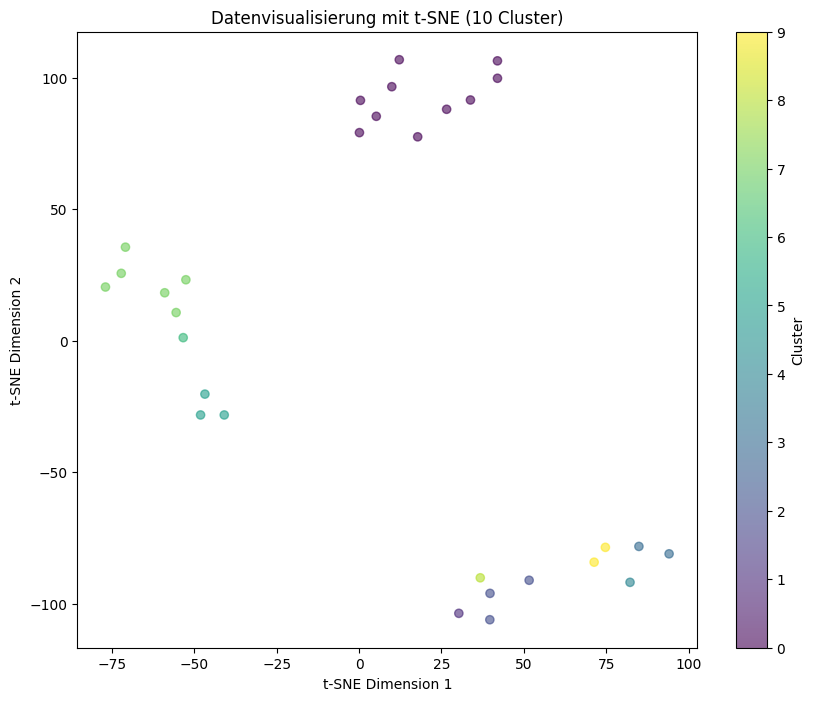

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(embs)

tsne = TSNE(n_components=2, perplexity=3, random_state=0)
data_2d = tsne.fit_transform(embs)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Datenvisualisierung mit t-SNE (10 Cluster)')
plt.show()


In [ ]:
# UMAP VISUALIZATION



In [ ]:
# Hier Cosin Similarity berechnen
# 1. Embeddings extrahieren
# 2. Cosin Similarity berechnen für jedes Paar (p,q)
# 3. Kostenmatrix
# 4. Correlation Clustering Solver
# 5. Evaluation mit Labels

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [2]:
# UMAP
# Use Values from Tensorboard vis:
# Values that work: 
# UMAP in 3D
# Neighbors 15
# MinDist 0.1
import umap.umap_ as umap

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    random_state=0
).fit_transform(embs)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    umap_3d[:, 0],
    umap_3d[:, 1],
    umap_3d[:, 2],
    c=clusters,
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

plt.title('3D Datenvisualisierung mit UMAP (10 Cluster)')
plt.show()

NameError: name 'embs' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity



# KNN
student_for_eval = student.module if isinstance(student, nn.DataParallel) else student
embs, imgs, labels = compute_embedding(student_for_eval.backbone, data_loader_val_plain_subset)

# Cosinus-Ähnlichkeitsmatrix berechnen
cosine_sim_matrix = cosine_similarity(embs)
euklidian_dist_matrix = np.linalg.norm(embs, axis=1)


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
#calc nmi
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans


model_for_embedding = student.module.backbone if isinstance(student, nn.DataParallel) else student.backbone
embs, imgs, labels = compute_embedding(model_for_embedding, data_loader_val_plain_subset)

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
clusters = kmeans.fit_predict(embs)

# kmeans pairwise accuracy
adjusted_rand_score(labels, clusters), normalized_mutual_info_score(labels, clusters)

(0.5833154621488312, 0.7176280846026692)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
len(data_loader_val_plain_subset.dataset.imgs)

30

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# cosine_sim_matrix werte sind alle zw. 0.988 und 1
# --> normalisieren

cosine_sim_matrix = (cosine_sim_matrix - cosine_sim_matrix.min()) / (cosine_sim_matrix.max() - cosine_sim_matrix.min())

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

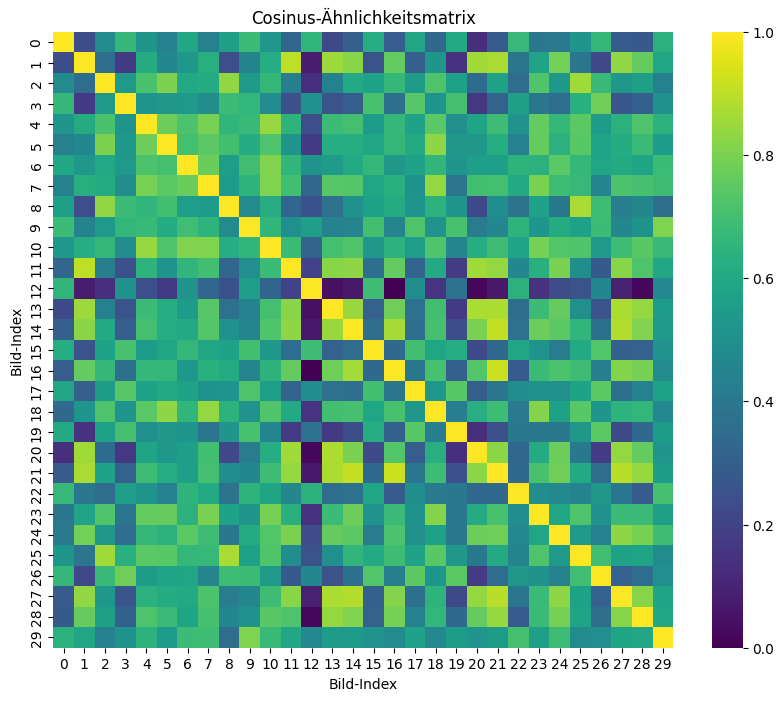

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Cosinus-Ähnlichkeitsmatrix visualisieren
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, cmap="viridis", cbar=True)
plt.title("Cosinus-Ähnlichkeitsmatrix")
plt.xlabel("Bild-Index")
plt.ylabel("Bild-Index")
plt.show()

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
cosine_sim_matrix

array([[0.99999917, 0.23399763, 0.47605005, 0.66486573, 0.5207344 ,
        0.43312678, 0.5951034 , 0.43416578, 0.5588687 , 0.68143857,
        0.5283513 , 0.32593122, 0.65427434, 0.2214605 , 0.3003162 ,
        0.620392  , 0.29163265, 0.58611643, 0.33558533, 0.60817415,
        0.13631661, 0.2817153 , 0.6698694 , 0.39500782, 0.40786117,
        0.52298325, 0.6634752 , 0.28185186, 0.27989215, 0.640231  ],
       [0.23399763, 0.99999887, 0.34888205, 0.17101525, 0.60993487,
        0.46818766, 0.5320049 , 0.6327164 , 0.23800503, 0.44866017,
        0.6245377 , 0.8996211 , 0.075906  , 0.8529553 , 0.82129717,
        0.25584176, 0.7594695 , 0.29878417, 0.5262899 , 0.14169209,
        0.8579114 , 0.8685122 , 0.39064518, 0.5807865 , 0.7870386 ,
        0.38935167, 0.21768065, 0.8357245 , 0.762702  , 0.5891264 ],
       [0.47605005, 0.34888205, 0.99999917, 0.53783286, 0.7120502 ,
        0.80216163, 0.5979328 , 0.61044693, 0.83214784, 0.5388806 ,
        0.6618392 , 0.4263198 , 0.13884738, 0.

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

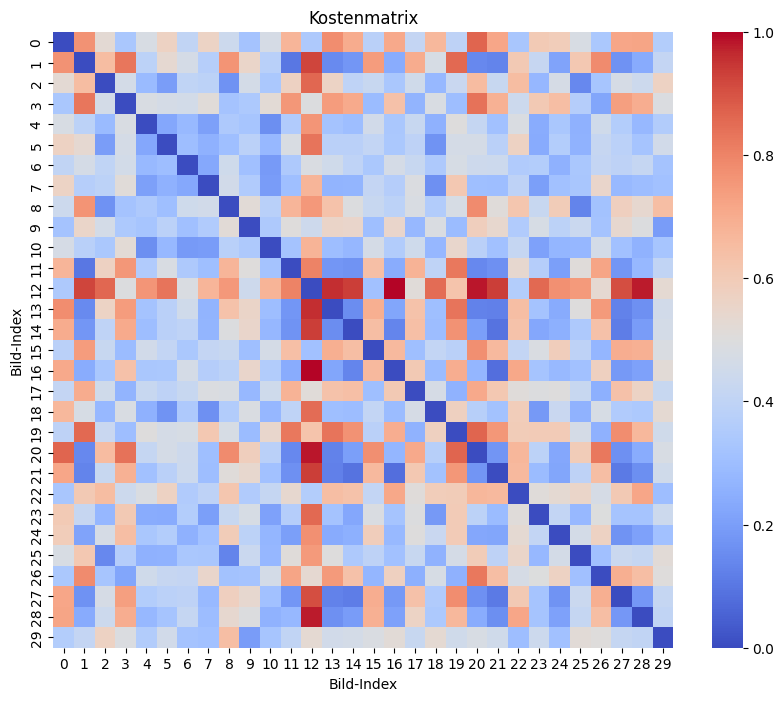

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Margin festlegen und Kostenmatrix berechnen
margin = 1.0
cost_matrix = margin - cosine_sim_matrix
# cost_matrix = cosine_sim_matrix

# Kostenmatrix visualisieren
plt.figure(figsize=(10, 8))
sns.heatmap(cost_matrix, cmap="coolwarm", cbar=True)
plt.title("Kostenmatrix")
plt.xlabel("Bild-Index")
plt.ylabel("Bild-Index")
plt.show()

In [ ]:
print("Ein Eintrag cost vs. similarity:", cost_matrix[0,1], cosine_sim_matrix[0,1])
print("Cost range:", cost_matrix.min(), cost_matrix.max())


Ein Eintrag cost vs. similarity: 0.76600236 0.23399763
Cost range: 0.0 1.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

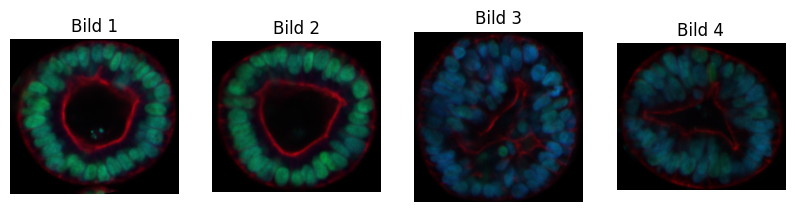

Cosinus-Ähnlichkeit zw 1&2: 0.23399763
Cosinus-Ähnlichkeit zw 1&3: 0.52298325
Cosinus-Ähnlichkeit zw 2&3: 0.38935167
Cosinus-Ähnlichkeit zw 3&4: 0.6941342
Cosinus-Ähnlichkeit zw 1&4: 0.6634752
Kosten zw 1&2: 0.76600236
Kosten zw 1&3: 0.47701675
Kosten zw 2&3: 0.61064833
Kosten zw 3&4: 0.30586582
Kosten zw 1&4: 0.33652478


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Show img pairs
img1 = data_loader_val_plain_subset.dataset.imgs[0]
img2 = data_loader_val_plain_subset.dataset.imgs[1]
img3 = data_loader_val_plain_subset.dataset.imgs[25]
img4 = data_loader_val_plain_subset.dataset.imgs[26]

img1 = Image.open(os.path.join(val_path, img1)).convert("RGB")
img2 = Image.open(os.path.join(val_path, img2)).convert("RGB")
img3 = Image.open(os.path.join(val_path, img3)).convert("RGB")
img4 = Image.open(os.path.join(val_path, img4)).convert("RGB")

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(img1)
axs[0].set_title("Bild 1")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Bild 2")
axs[1].axis("off")

axs[2].imshow(img3)
axs[2].set_title("Bild 3")
axs[2].axis("off")

axs[3].imshow(img4)
axs[3].set_title("Bild 4")
axs[3].axis("off")

plt.show()

# Ähnlichkeitswerte:
print("Cosinus-Ähnlichkeit zw 1&2:", cosine_sim_matrix[0, 1])
print("Cosinus-Ähnlichkeit zw 1&3:", cosine_sim_matrix[0, 25])
print("Cosinus-Ähnlichkeit zw 2&3:", cosine_sim_matrix[1, 25])
print("Cosinus-Ähnlichkeit zw 3&4:", cosine_sim_matrix[25, 26])
print("Cosinus-Ähnlichkeit zw 1&4:", cosine_sim_matrix[0, 26])

# Kostenwerte:
print("Kosten zw 1&2:", cost_matrix[0, 1])
print("Kosten zw 1&3:", cost_matrix[0, 25])
print("Kosten zw 2&3:", cost_matrix[1, 25])
print("Kosten zw 3&4:", cost_matrix[25, 26])
print("Kosten zw 1&4:", cost_matrix[0, 26])


In [ ]:
# Debug: Matrizen auf 4 Bilder reduzieren:
# 0,1,25,26 behalten!

# cosine_sim_matrix = cosine_sim_matrix[[0, 1, 25, 26]][:, [0, 1, 25, 26]]
# cost_matrix = 1.0 - cosine_sim_matrix

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import cvxpy as cp

# Step 1: Cost matrix
num_images = cost_matrix.shape[0]

# Step 2: Create binary decision variables for each pair (y_pq)
y = cp.Variable((num_images, num_images), boolean=True)

# step 3: Objective function to minimize the total cost of clustering
term1 = cp.multiply(cosine_sim_matrix, (1 - y))      # cost if separated
term2 = cp.multiply(1 - cosine_sim_matrix, y)       # cost if joined
objective = cp.Minimize(cp.sum(term1 + term2))

# Step 5: constraints für problem
constraints = []

# Transitivity constraint: for all triples (p, q, r), y_pq + y_qr - y_pr <= 1
for p in tqdm.tqdm(range(num_images), desc='Transitivity constraints'):
    for q in range(num_images):
        if p != q:
            for r in range(num_images):
                if r != p and r != q and r != q:
                    # Dreimal Dreiecks-Ungleichung:
                    constraints.append(y[p,q] + y[q,r] - y[p,r] <= 1)
                    constraints.append(y[p,q] + y[p,r] - y[q,r] <= 1)
                    constraints.append(y[p,r] + y[q,r] - y[p,q] <= 1)

# selbst symmetrisch
for p in range(num_images):
    constraints.append(y[p,p] == 1)

# Step 6: Symmetry constraint (y_pq = y_qp)
for p in tqdm.tqdm(range(num_images), 'Symmetry constraints'):
    for q in range(p + 1, num_images):
        constraints.append(y[p, q] == y[q, p])


# # Step 7: Solve the optimization problem
## Your problem has 10000 variables, 975150 constraints, and 0 parameters. ! mind. O(n^3) --> dauert sehr lang!
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GLPK_MI, verbose=True)
# problem.solve(solver=cp.GUROBI, verbose=True)

Symmetry constraints: 100%|██████████| 30/30 [00:00<00:00, 882.81it/s]


                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jan 15 12:03:14 PM: Your problem has 900 variables, 73545 constraints, and 0 parameters.
(CVXPY) Jan 15 12:03:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 15 12:03:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 15 12:03:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 15 12:03:19 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 15 12:03:24 PM: Compiling problem (target solver=GLPK_M

320.6428144611418

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
print(problem.status)
print(problem.value)

optimal
320.6428144611418


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
y.value

array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# Step 8: Extract the clustering results
cluster_assignments = y.value
clusters = {}

# Assign clusters based on the solution
for i in range(num_images):
    for j in range(i + 1, num_images):
        if cluster_assignments[i, j] > 0.5:  # If y_pq is 1, they are in the same cluster
            if i in clusters:
                clusters[i].append(j)
            else:
                clusters[i] = [j]

# Print the resulting clusters
for cluster_id, members in clusters.items():
    print(f"Cluster {cluster_id}: {sorted([cluster_id] + members)}")


Cluster 0: [0, 3, 9, 12, 15, 17, 19, 22, 26]
Cluster 1: [1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 2: [2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 3: [3, 9, 12, 15, 17, 19, 22, 26]
Cluster 4: [4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 5: [5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 6: [6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 7: [7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 8: [8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 9: [9, 12, 15, 17, 19, 22, 26]
Cluster 10: [10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 11: [11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 12: [12, 15, 17, 19, 22, 26]
Cluster 13: [13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 14: [14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]
Cluster 15: [15, 17, 19, 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
cluster_assignments

array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import networkx as nx

G_sol = nx.Graph()
G_sol.add_nodes_from(range(num_images))

# Aus der y.value-Matrix die Kanten bauen
for i in range(num_images):
    for j in range(i+1, num_images):
        if y.value[i, j] > 0.5:  # oder eine Toleranz
            G_sol.add_edge(i, j)

# Connected Components bestimmen
components = list(nx.connected_components(G_sol))

# Jede Komponente ist ein Cluster
clusters = [list(comp) for comp in components]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
clusters

[[0, 3, 9, 12, 15, 17, 19, 22, 26],
 [1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]]

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import networkx as nx

# Angenommen, du hast die ILP gelöst und "y.value" ist deine (N x N)-Matrix.
# "num_images" = N.

G_sol = nx.Graph()
G_sol.add_nodes_from(range(num_images))  # Knoten 0..N-1

for i in range(num_images):
    for j in range(i + 1, num_images):
        # Ist y_{ij} > 0.5? => Dann legen wir eine Kante an => "zusammen im Cluster"
        if y.value[i, j] > 0.5:  
            G_sol.add_edge(i, j)

# Jetzt Connected Components bestimmen
components = list(nx.connected_components(G_sol))

# Jede Komponente ist ein disjunkter Cluster
clusters = [sorted(list(comp)) for comp in components]

print("Gefundene Cluster:")
for idx, c in enumerate(clusters):
    print(f"Cluster {idx}: {c}")

Gefundene Cluster:
Cluster 0: [0, 3, 9, 12, 15, 17, 19, 22, 26]
Cluster 1: [1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 18, 20, 21, 23, 24, 25, 27, 28, 29]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# DBSCAN

from sklearn.cluster import DBSCAN

# DBSCAN-Modell instanziieren
dbscan = DBSCAN(eps=0.8, min_samples=2, metric='cosine')
# do fit
dbscan.fit(embs)

# Cluster-Labels
dbscan.labels_

# Anzahl der Cluster
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

print(f"Anzahl der Cluster: {n_clusters}")
print(f"Cluster-Labels: {dbscan.labels_}")
ground_truth = np.array(labels)
print(ground_truth)

# NMI berechnen
nmi = normalized_mutual_info_score(ground_truth, dbscan.labels_)
print(f"NMI: {nmi}")

Anzahl der Cluster: 1
Cluster-Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[10 12 12 11 10 11 11 12 10 11 10 12 12 11 11 12 12 12 11 11 12 10 12 10
 11 11 10 10 10 10]
NMI: 0.0


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
cost_matrix

array([[8.34465027e-07, 7.66002357e-01, 5.23949981e-01, 3.35134268e-01,
        4.79265571e-01, 5.66873193e-01, 4.04896617e-01, 5.65834224e-01,
        4.41131294e-01, 3.18561435e-01, 4.71648693e-01, 6.74068809e-01,
        3.45725656e-01, 7.78539479e-01, 6.99683785e-01, 3.79607975e-01,
        7.08367348e-01, 4.13883567e-01, 6.64414644e-01, 3.91825855e-01,
        8.63683403e-01, 7.18284726e-01, 3.30130577e-01, 6.04992151e-01,
        5.92138827e-01, 4.77016747e-01, 3.36524785e-01, 7.18148112e-01,
        7.20107853e-01, 3.59768987e-01],
       [7.66002357e-01, 1.13248825e-06, 6.51117921e-01, 8.28984737e-01,
        3.90065134e-01, 5.31812310e-01, 4.67995107e-01, 3.67283583e-01,
        7.61994958e-01, 5.51339865e-01, 3.75462294e-01, 1.00378871e-01,
        9.24094021e-01, 1.47044718e-01, 1.78702831e-01, 7.44158268e-01,
        2.40530491e-01, 7.01215863e-01, 4.73710120e-01, 8.58307898e-01,
        1.42088592e-01, 1.31487787e-01, 6.09354854e-01, 4.19213474e-01,
        2.12961376e-01,

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from sklearn.cluster import DBSCAN



"""
eps: float, default=0.5
- The maximum distance between two samples for one to be considered as in the neighborhood of the other.
- This is not a maximum bound on the distances of points within a cluster.
- This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

min_samples: int, default=5
- The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
- This includes the point itself.
- If min_samples is set to a higher value, DBSCAN will find denser clusters,
whereas if it is set to a lower value, the found clusters will be more sparse.


!! Noisy Samples sind label -1 !
"""

@widgets.interact
def visualize_dataset(
    eps=widgets.FloatSlider(min=0.1, max=10, step=0.1, continuous_update=True, description="Epsilon"),
    min_samples=widgets.IntSlider(min=1, max=50, continuous_update=True),
):
  
  print(f"eps={eps}, min_samples={min_samples}")
  
  dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
  dbscan.fit(embs)

  n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
  n_noise_ = list(dbscan.labels_).count(-1)

  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)

interactive(children=(FloatSlider(value=0.1, description='Epsilon', max=10.0, min=0.1), IntSlider(value=1, des…

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
print(ground_truth)

[10 12 12 11 10 11 11 12 10 11 10 12 12 11 11 12 12 12 11 11 12 10 12 10
 11 11 10 10 10 10]


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
"""
todo: HDBSCAN 
The HDBSCAN algorithm can be seen as an extension of DBSCAN and OPTICS.
Specifically, DBSCAN assumes that the clustering criterion (i.e. density requirement) is globally homogeneous.
In other words, DBSCAN may struggle to successfully capture clusters with different densities.
HDBSCAN alleviates this assumption and explores all possible density scales by
building an alternative representation of the clustering problem.
"""

'\ntodo: HDBSCAN \nThe HDBSCAN algorithm can be seen as an extension of DBSCAN and OPTICS.\nSpecifically, DBSCAN assumes that the clustering criterion (i.e. density requirement) is globally homogeneous.\nIn other words, DBSCAN may struggle to successfully capture clusters with different densities.\nHDBSCAN alleviates this assumption and explores all possible density scales by\nbuilding an alternative representation of the clustering problem.\n'

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 